In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

from fastai.datasets import Config

base_path = Config.data_path()

In [5]:
%%time

gbm = GradientBoostingClassifier(
    n_estimators=300, 
    learning_rate=0.5,
    max_depth=5, 
    random_state=0
).fit(
    X_train,
    y_train
)

probas = gbm.predict_proba(X_test)

print(f"Gradient Boosting auc score: {roc_auc_score(y_test, probas[:, 1])}")

print(f"Gradient Boosting score: {gbm.score(X_test, y_test)}") 

Random Forest auc score: 0.9899831697230198
Gradient Boosting score: 0.9425
CPU times: user 5.1 s, sys: 0 ns, total: 5.1 s
Wall time: 5.1 s


In [7]:
%%time

rforest = RandomForestClassifier(n_estimators=500)

rforest.fit(
    X_train,
    y_train
)

probas = rforest.predict_proba(X_test)

print(f"Random Forest auc score: {roc_auc_score(y_test, probas[:, 1])}")

print(f"Random Forest score: {rforest.score(X_test, y_test)}") 

Random Forest auc score: 0.9635806292618802
Random Forest score: 0.9
CPU times: user 18.6 s, sys: 0 ns, total: 18.6 s
Wall time: 18.6 s


In [28]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': range(50, 250, 50)
}

learner = GradientBoostingClassifier(
    learning_rate=0.5,
    max_depth=5, 
    random_state=0
)

clf = GridSearchCV(
    estimator=learner,
    param_grid=parameters
).fit(
    X_train,
    y_train
)

/home/krzysiek/anaconda3/envs/kaggle_sandbox/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [96]:
clf.best_params_['n_estimators']

150

In [33]:
clf.best_score_

0.9273958333333333

In [111]:
# Parametr tuning

learner = GradientBoostingClassifier(
    random_state=0
)

range_dacay = 10
num_of_stages = 2
# Stage I

# for i in range(2):    

parameters = {
    'n_estimators': {
        'current_value': 500,
        'search_range': 990
    },
    'learning_rate': {
        'current_value': 0.5,
        'search_range': 0.99
    },
    'max_depth': {
        'current_value': 5,
        'search_range': 8
    }
}

for i in range(1, num_of_stages + 1):
    print(f"Starting Stage {i}...")
    params_to_tune = {
        'n_estimators': list(map(int, range_from_mid_point(
            parameters['n_estimators']['current_value'],
            parameters['n_estimators']['search_range']))),
        'learning_rate': range_from_mid_point(
            parameters['learning_rate']['current_value'],
            parameters['learning_rate']['search_range']),
        'max_depth': list(map(int, range_from_mid_point(
            parameters['max_depth']['current_value'],
            parameters['max_depth']['search_range'])))
    }

    tuner = GridSearchCV(
        estimator=learner,
        param_grid=params_to_tune
    ).fit(
        X_train,
        y_train
    )

    print(f"Stage {i} complete")
    print(f"Best result: {tuner.best_score_}")
    print(f"Best paramteres: {tuner.best_params_}")

    parameters = {
        'n_estimators': {
            'current_value': tuner.best_params_['n_estimators'],
            'search_rage': parameters['n_estimators']['search_range']/range_dacay
        },
        'learning_rate': {
            'current_value': tuner.best_params_['learning_rate'],
            'search_rage': parameters['n_estimators']['learning_rate']/range_dacay
        },
        'max_depth': {
            'current_value': tuner.best_params_['max_depth'],
            'search_rage': parameters['n_estimators']['max_depth']/range_dacay
        }
    }

print(f"Final result: {tuner.best_score_}")

Starting Stage 1...


/home/krzysiek/anaconda3/envs/kaggle_sandbox/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [110]:
list(map(int, range_from_mid_point(
            parameters['max_depth']['current_value'],
            8)))

[1, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [88]:
mid = 5
magnitude = 10

def range_from_mid_point(mid, search_range):
    start = mid - search_range/2
    stop = mid + search_range/2
    return list(np.linspace(start, stop, 10))
# list(range(start, stop, num_of_points//(stop-start)))

In [91]:
range_from_mid_point(5, 10)

[0.0,
 1.1111111111111112,
 2.2222222222222223,
 3.3333333333333335,
 4.444444444444445,
 5.555555555555555,
 6.666666666666667,
 7.777777777777779,
 8.88888888888889,
 10.0]

In [1]:
!pip install hyperopt

    100% |████████████████████████████████| 122kB 804kB/s ta 0:00:01
    100% |████████████████████████████████| 409kB 955kB/s ta 0:00:01    40% |█████████████                   | 163kB 609kB/s eta 0:00:01
    100% |████████████████████████████████| 1.7MB 767kB/s ta 0:00:01    69% |██████████████████████▏         | 1.2MB 889kB/s eta 0:00:01
    100% |████████████████████████████████| 829kB 741kB/s ta 0:00:01
  Stored in directory: /home/krzysiek/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
  Stored in directory: /home/krzysiek/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built networkx future


In [8]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(x):
    return {
        'loss': x ** 2,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # -- attachments are handled differently
        'attachments':
            {'time_module': pickle.dumps(time.time)}
        }
trials = Trials()
best = fmin(objective,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)
print(best)

100%|██████████| 100/100 [00:00<00:00, 214.31it/s, best loss: 0.00019734038263869786]
{'x': -0.014047789243816902}


In [12]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 39.99937924352154,
   'status': 'ok',
   'eval_time': 1553538697.515399,
   'other_stuff': {'type': None, 'value': [0, 1, 2]}},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'x': [0]},
   'vals': {'x': [-6.324506245037753]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2019, 3, 25, 18, 31, 37, 515000),
  'refresh_time': datetime.datetime(2019, 3, 25, 18, 31, 37, 517000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 84.00431925663726,
   'status': 'ok',
   'eval_time': 1553538697.5195892,
   'other_stuff': {'type': None, 'value': [0, 1, 2]}},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'x': [1]},
   'vals': {'x': [9.165387021650382]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2019, 3, 25, 18, 31, 37, 5190

# Competiton files setup

In [2]:
data_path = base_path/'santander'
competition_name = 'santander-customer-transaction-prediction'
data_path.mkdir(parents=True, exist_ok=True)
data_path

PosixPath('/home/jupyter/.fastai/data/santander')

In [4]:
!kaggle competitions files -c {competition_name}

name                    size  creationDate         
---------------------  -----  -------------------  
train.csv              288MB  2019-02-12 01:02:37  
sample_submission.csv    3MB  2019-02-12 00:59:50  
test.csv               288MB  2019-02-12 01:02:37  


In [5]:
!kaggle competitions download -c {competition_name} -p {data_path}

 99%|███████████████████████████████████████▌| 121M/122M [00:01<00:00, 64.6MB/s]
100%|████████████████████████████████████████| 122M/122M [00:01<00:00, 78.3MB/s]
  0%|                                                | 0.00/463k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 463k/463k [00:00<00:00, 206MB/s]
 88%|███████████████████████████████████     | 107M/122M [00:01<00:00, 57.8MB/s]
100%|████████████████████████████████████████| 122M/122M [00:01<00:00, 86.0MB/s]


In [3]:
data_path.ls()

[PosixPath('/home/jupyter/.fastai/data/santander/test.csv'),
 PosixPath('/home/jupyter/.fastai/data/santander/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/santander/sample_submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/santander/submission_my2_lgbm.csv'),
 PosixPath('/home/jupyter/.fastai/data/santander/submission_my_lgbm.csv')]

In [10]:
from zipfile import ZipFile

# Need to unzip all files in the folder
def unzip_and_remove(file_name):
    print(f"Unziping {file_name}")
    
    with ZipFile(data_path/file_name,"r") as zip_ref:
        zip_ref.extractall(data_path)
        
    print(f"Done. Deleting {file_name}")
    os.remove(data_path/file_name)
    print("Done")

unzip_and_remove('sample_submission.csv.zip')
unzip_and_remove('train.csv.zip')
unzip_and_remove('test.csv.zip')

Unziping sample_submission.csv.zip
Done. Deleting sample_submission.csv.zip
Done
Unziping train.csv.zip
Done. Deleting train.csv.zip
Done
Unziping test.csv.zip
Done. Deleting test.csv.zip
Done


In [11]:
data_path.ls()

[PosixPath('/home/jupyter/.fastai/data/santander/test.csv'),
 PosixPath('/home/jupyter/.fastai/data/santander/train.csv'),
 PosixPath('/home/jupyter/.fastai/data/santander/sample_submission.csv')]

# Data exploration

In [4]:
train_df = pd.read_csv(data_path/'train.csv')
test_df = pd.read_csv(data_path/'test.csv')
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [6]:
print(f"Train length: {len(train_df)}")
print(f"Test length: {len(test_df)}")

Train length: 200000
Test length: 200000


In [20]:
# Only for demonstration purposes - not a valid test set
sample_submission_df = pd.read_csv(data_path/'sample_submission.csv')
sample_submission_df.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [7]:
final_train_df = train_df.drop(['ID_code', 'target'], axis=1)
final_train = final_train_df.to_numpy()
final_target = train_df['target'].to_numpy()

# Add scaler
#############################
X_scaler = StandardScaler()
final_train = X_scaler.fit_transform(final_train)
#############################

X_train, X_valid, Y_train, Y_valid = train_test_split(final_train, final_target, test_size=0.13)

In [8]:
X_test = test_df.drop('ID_code', axis=1).to_numpy()

# Add scaler
#############################
X_test = X_scaler.fit_transform(X_test)
#############################

# Model Selection

In [13]:
%%time

rforest = RandomForestClassifier(n_estimators=50)

rforest.fit(
    X_train,
    Y_train
)

probas = rforest.predict_proba(X_valid)

print(f"Random Forest auc score: {roc_auc_score(Y_valid, probas[:, 1])}")

print(f"Random Forest score: {rforest.score(X_valid, Y_valid)}") 

KeyboardInterrupt: 

In [9]:
lgb_train_data = lgb.Dataset(X_train, label=Y_train)
lgb_validation_data = lgb.Dataset(X_valid, label=Y_valid, reference=lgb_train_data)

In [42]:
%%time

lgb_params = {
    'num_leaves': 50,
    'num_trees': 300,
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05
}

lgb_model = lgb.train(
    lgb_params,
    lgb_train_data,
    num_boost_round=100,
    valid_sets=[lgb_validation_data]
)

print(f"Basic Light GMB auc score: {lgb_model.best_score['valid_0']['auc']}")

[1]	valid_0's auc: 0.674081
[2]	valid_0's auc: 0.694263
[3]	valid_0's auc: 0.702831
[4]	valid_0's auc: 0.709935
[5]	valid_0's auc: 0.715899
[6]	valid_0's auc: 0.722475
[7]	valid_0's auc: 0.729091
[8]	valid_0's auc: 0.73218
[9]	valid_0's auc: 0.737665
[10]	valid_0's auc: 0.742146
[11]	valid_0's auc: 0.748075
[12]	valid_0's auc: 0.752288
[13]	valid_0's auc: 0.758753
[14]	valid_0's auc: 0.763041
[15]	valid_0's auc: 0.765842
[16]	valid_0's auc: 0.769002
[17]	valid_0's auc: 0.772618
[18]	valid_0's auc: 0.775094
[19]	valid_0's auc: 0.777052
[20]	valid_0's auc: 0.779371
[21]	valid_0's auc: 0.78271
[22]	valid_0's auc: 0.784726
[23]	valid_0's auc: 0.787236
[24]	valid_0's auc: 0.790568
[25]	valid_0's auc: 0.79146
[26]	valid_0's auc: 0.793654
[27]	valid_0's auc: 0.795004
[28]	valid_0's auc: 0.797132
[29]	valid_0's auc: 0.798288
[30]	valid_0's auc: 0.79989
[31]	valid_0's auc: 0.801473
[32]	valid_0's auc: 0.802554
[33]	valid_0's auc: 0.80352
[34]	valid_0's auc: 0.804921
[35]	valid_0's auc: 0.806511

[279]	valid_0's auc: 0.880472
[280]	valid_0's auc: 0.88052
[281]	valid_0's auc: 0.880547
[282]	valid_0's auc: 0.880575
[283]	valid_0's auc: 0.880639
[284]	valid_0's auc: 0.880688
[285]	valid_0's auc: 0.880772
[286]	valid_0's auc: 0.880854
[287]	valid_0's auc: 0.880952
[288]	valid_0's auc: 0.880971
[289]	valid_0's auc: 0.881032
[290]	valid_0's auc: 0.881089
[291]	valid_0's auc: 0.881132
[292]	valid_0's auc: 0.881146
[293]	valid_0's auc: 0.881212
[294]	valid_0's auc: 0.881251
[295]	valid_0's auc: 0.881304
[296]	valid_0's auc: 0.881455
[297]	valid_0's auc: 0.881505
[298]	valid_0's auc: 0.881607
[299]	valid_0's auc: 0.881667
[300]	valid_0's auc: 0.88174
Basic Light GMB auc score: 0.8817400793475556
CPU times: user 1min 49s, sys: 96 ms, total: 1min 49s
Wall time: 27.2 s


In [10]:
%%time

param = {
    'num_leaves': 18,
    'num_trees': 500,
    'max_bin': 50,
    'min_data_in_leaf': 50,
    'learning_rate': 0.11,
    'min_sum_hessian_in_leaf': 0.0093586657313989123,
    'feature_fraction': 0.056701788569420042,
    'lambda_l1': 0.060222413158420585,
    'lambda_l2': 4.6580550589317573,
    'min_gain_to_split': 0.29588543202055562,
    'max_depth': 49,
    'seed': 1337,
    'feature_fraction_seed': 1337,
    'bagging_seed': 1337,
    'drop_seed': 1337,
    'data_random_seed': 1337,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'is_unbalance': True,
    'boost_from_average': True
}

lgb_model = lgb.train(
    param,
    lgb_train_data,
    num_boost_round=100,
    valid_sets=[lgb_validation_data]
)

print(f"Tuned Light GMB auc score: {lgb_model.best_score['valid_0']['auc']}")

/opt/anaconda3/envs/kaggle_sandbox/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.590264
[2]	valid_0's auc: 0.621304
[3]	valid_0's auc: 0.643195
[4]	valid_0's auc: 0.663537
[5]	valid_0's auc: 0.676956
[6]	valid_0's auc: 0.698499
[7]	valid_0's auc: 0.701207
[8]	valid_0's auc: 0.713654
[9]	valid_0's auc: 0.723502
[10]	valid_0's auc: 0.733743
[11]	valid_0's auc: 0.743067
[12]	valid_0's auc: 0.749005
[13]	valid_0's auc: 0.760407
[14]	valid_0's auc: 0.762002
[15]	valid_0's auc: 0.765338
[16]	valid_0's auc: 0.772104
[17]	valid_0's auc: 0.778668
[18]	valid_0's auc: 0.785276
[19]	valid_0's auc: 0.788746
[20]	valid_0's auc: 0.795126
[21]	valid_0's auc: 0.797617
[22]	valid_0's auc: 0.799009
[23]	valid_0's auc: 0.803508
[24]	valid_0's auc: 0.808821
[25]	valid_0's auc: 0.811959
[26]	valid_0's auc: 0.813871
[27]	valid_0's auc: 0.819454
[28]	valid_0's auc: 0.822119
[29]	valid_0's auc: 0.824597
[30]	valid_0's auc: 0.823368
[31]	valid_0's auc: 0.825781
[32]	valid_0's auc: 0.827927
[33]	valid_0's auc: 0.829083
[34]	valid_0's auc: 0.830887
[35]	valid_0's auc: 0.8

[285]	valid_0's auc: 0.892485
[286]	valid_0's auc: 0.892489
[287]	valid_0's auc: 0.892489
[288]	valid_0's auc: 0.892501
[289]	valid_0's auc: 0.892477
[290]	valid_0's auc: 0.892409
[291]	valid_0's auc: 0.892445
[292]	valid_0's auc: 0.892512
[293]	valid_0's auc: 0.892536
[294]	valid_0's auc: 0.892582
[295]	valid_0's auc: 0.892619
[296]	valid_0's auc: 0.892608
[297]	valid_0's auc: 0.892603
[298]	valid_0's auc: 0.892548
[299]	valid_0's auc: 0.892564
[300]	valid_0's auc: 0.892647
[301]	valid_0's auc: 0.892584
[302]	valid_0's auc: 0.892661
[303]	valid_0's auc: 0.892659
[304]	valid_0's auc: 0.892685
[305]	valid_0's auc: 0.892604
[306]	valid_0's auc: 0.892693
[307]	valid_0's auc: 0.892694
[308]	valid_0's auc: 0.892737
[309]	valid_0's auc: 0.892776
[310]	valid_0's auc: 0.892816
[311]	valid_0's auc: 0.892769
[312]	valid_0's auc: 0.8928
[313]	valid_0's auc: 0.892792
[314]	valid_0's auc: 0.892802
[315]	valid_0's auc: 0.89276
[316]	valid_0's auc: 0.892694
[317]	valid_0's auc: 0.892749
[318]	valid_0

In [94]:
probs = lgb_model.predict(X_test)

In [31]:
from sklearn.model_selection import StratifiedKFold

params = {
    'num_leaves': 18,
    'num_trees': 500,
    'max_bin': 50,
    'min_data_in_leaf': 50,
    'learning_rate': 0.11,
    'min_sum_hessian_in_leaf': 0.0093586657313989123,
    'feature_fraction': 0.056701788569420042,
    'lambda_l1': 0.060222413158420585,
    'lambda_l2': 4.6580550589317573,
    'min_gain_to_split': 0.29588543202055562,
    'max_depth': 49,
    'seed': 1337,
    'feature_fraction_seed': 1337,
    'bagging_seed': 1337,
    'drop_seed': 1337,
    'data_random_seed': 1337,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'is_unbalance': True,
    'boost_from_average': True
}

nbr_of_folds = 10

folds = StratifiedKFold(
    n_splits=nbr_of_folds,
    shuffle=True,
    random_state=459
)

out_of_fold_predictions = np.zeros(len(final_train))
test_predictions = np.zeros(len(X_test))

for fold_nbr, (train_idx, valid_idx) in enumerate(folds.split(final_train, final_target)):
    print(f"Fold #{fold_nbr}")

    train_batch = lgb.Dataset(final_train[train_idx], label=final_target[train_idx])
    valid_batch = lgb.Dataset(final_train[valid_idx], label=final_target[valid_idx], reference=train_batch)
    
    model = lgb.train(params, train_batch, valid_sets=[valid_batch], verbose_eval=250)
    
    out_of_fold_predictions[valid_idx] = model.predict(final_train[valid_idx])
    test_predictions += model.predict(X_test)
    
    print("-" * 20)
    
test_predictions /= nbr_of_folds

print(f"Final auc score: {roc_auc_score(final_target, out_of_fold_predictions)}")

Fold #0


/opt/anaconda3/envs/kaggle_sandbox/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	valid_0's auc: 0.8929
[500]	valid_0's auc: 0.899682
--------------------
Fold #1
[250]	valid_0's auc: 0.890226
[500]	valid_0's auc: 0.895279
--------------------
Fold #2
[250]	valid_0's auc: 0.888069
[500]	valid_0's auc: 0.894385
--------------------
Fold #3
[250]	valid_0's auc: 0.885824
[500]	valid_0's auc: 0.891479
--------------------
Fold #4
[250]	valid_0's auc: 0.884899
[500]	valid_0's auc: 0.891244
--------------------
Fold #5
[250]	valid_0's auc: 0.884003
[500]	valid_0's auc: 0.891535
--------------------
Fold #6
[250]	valid_0's auc: 0.889111
[500]	valid_0's auc: 0.894583
--------------------
Fold #7
[250]	valid_0's auc: 0.88504
[500]	valid_0's auc: 0.890631
--------------------
Fold #8
[250]	valid_0's auc: 0.893059
[500]	valid_0's auc: 0.898797
--------------------
Fold #9
[250]	valid_0's auc: 0.891961
[500]	valid_0's auc: 0.897988
--------------------
Final auc score: 0.8945654215545371


In [20]:
len(final_train)

200000

In [17]:
a = np.array([1, 2, 3, 4, 5])
a[[2, 3]]

array([3, 4])

# Final data preparation

In [15]:
# Limit nbr of samples for experimentation; this cell needs to be commented during actual training
train_df = train_df.iloc[:500].copy()
test_df = test_df.iloc[:500].copy()

In [6]:

param = {
    'num_leaves': 18,
     'max_bin': 63,
     'min_data_in_leaf': 5,
     'learning_rate': 0.010614430970330217,
     'min_sum_hessian_in_leaf': 0.0093586657313989123,
     'feature_fraction': 0.056701788569420042,
     'lambda_l1': 0.060222413158420585,
     'lambda_l2': 4.6580550589317573,
     'min_gain_to_split': 0.29588543202055562,
     'max_depth': 49,
     'save_binary': True,
     'seed': 1337,
     'feature_fraction_seed': 1337,
     'bagging_seed': 1337,
     'drop_seed': 1337,
     'data_random_seed': 1337,
     'objective': 'binary',
     'boosting_type': 'gbdt',
     'verbose': 1,
     'metric': 'auc',
     'is_unbalance': True,
     'boost_from_average': False
}

In [7]:
dep_var = 'target' # Variable to predict

final_train_df = train_df.drop(columns=['ID_code'])
final_test_df = test_df.drop(columns=['ID_code'])

# Looks like all parameters are continuous so there is no need to split
# Need to explicitly set cont_vars because TabularList doesn't assume that 
# columns are continuous if they are no categorical or dependant (TabularDataBunch has this feature) 
cont_vars = list(final_test_df) 

In [8]:
# Will treat all parameters as continuous
test = TabularList.from_df(final_test_df, path=data_path)

data = (TabularList
        .from_df(final_train_df, path=data_path, cont_names=cont_vars, procs=procs)
        .random_split_by_pct()
        .label_from_df(cols=dep_var)
        .add_test(test)
        .databunch()
       )

In [16]:
data.show_batch()

var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0.2004,0.2960,1.0500,-0.0673,-0.4089,0.6711,-0.4069,1.0217,1.0263,0.6565,1.5268,0.8167,1.2593,-2.3043,-0.8080,-1.3835,-0.6073,-1.5901,0.3231,0.5643,-1.6583,-0.8125,0.3188,0.5817,-0.6850,0.5497,-0.2345,0.5022,0.9414,-0.3996,-1.4985,-0.8241,0.7920,-1.3404,0.6617,1.0981,-0.5647,-0.2710,1.6160,-0.0882,-0.9113,1.6526,0.9622,0.7152,0.5417,0.5763,0.4293,0.8946,0.6250,2.2653,2.2440,1.5417,-0.3654,-0.6768,0.7735,0.2811,1.1062,-0.9019,0.0615,-1.4081,1.2150,0.4438,0.4672,-0.1638,0.7003,0.5682,-1.3287,0.6661,-1.7397,-0.7639,1.4584,0.8320,-1.8564,-1.1250,-0.8005,1.2604,0.2534,-1.5352,-1.1059,0.2897,0.4151,0.7609,1.0571,1.0844,-0.7478,0.8996,1.1136,1.0509,0.8349,-1.5914,-0.9096,0.1843,-0.7029,0.5746,1.0334,-1.4181,-0.7558,-0.2828,-0.0429,0.7651,-0.8473,0.2035,-1.0748,-0.5539,-0.6397,-1.1864,1.9205,-0.8207,0.6054,0.3993,-0.8383,0.7457,0.3988,-0.4939,0.7405,-1.3268,-1.4345,-2.1522,1.4496,1.2063,-0.4232,-1.1497,-0.4102,-0.7433,-0.4875,1.8793,0.1925,0.6663,1.7575,-0.2407,-0.8184,0.3340,0.8759,-1.1183,-0.2040,-0.0735,0.7979,-0.9199,1.5735,0.3515,-1.4248,0.8057,0.4436,0.5146,0.3123,-0.8881,0.9007,-0.9491,-0.0738,0.1843,0.0828,0.8462,0.7438,0.8926,0.5028,0.9767,-1.2251,0.1578,1.2172,-1.5648,-0.8329,1.5176,-1.2142,-0.7337,1.0021,0.7319,-0.0876,-0.0788,-1.1800,-1.2143,1.4788,-1.5164,0.7998,-1.5400,-0.6240,-1.2522,-0.3479,-0.7497,0.1784,0.2752,0.2008,-2.4512,0.5492,0.8144,-0.0356,-0.6370,1.0049,1.0778,0.7149,0.8001,1.3105,-1.9609,-0.0544,1.6340,0.0989,-0.5978,0.9137,1.6811,0.0923,-0.3148,0
0.9286,-0.2883,1.4299,-0.2120,-1.8992,1.2715,0.0480,2.0955,1.1153,-0.6978,-1.1431,2.4766,1.0589,-0.8651,-1.6954,0.0970,0.3107,0.0909,0.3658,-1.3475,0.3620,0.4045,-1.0535,1.5327,0.5691,-0.4653,2.7313,0.4084,1.4889,1.1097,-0.9927,-0.5094,0.1306,0.4244,0.9882,-1.9270,-1.8869,-0.8472,0.9364,1.1260,0.9683,-0.6809,1.4682,-1.3367,0.8405,-1.3397,1.1063,-0.2483,-1.7031,1.6028,-0.4281,-0.7337,-0.4647,-0.2542,-0.5390,-0.3629,-0.3498,0.0249,0.0186,-0.8806,-0.6318,-0.5348,0.4619,-0.1843,0.3385,2.0361,0.6795,-0.3041,0.2924,1.5207,0.1005,0.0536,2.0631,0.4937,-0.9092,0.2300,0.7043,-1.2001,1.1163,0.1563,-0.8255,1.8838,-1.7237,0.6130,-0.5589,0.0601,0.5435,-0.1335,-0.2984,1.4063,0.7600,-1.0320,0.7916,-0.7669,-1.8521,-0.0174,1.6987,-0.2390,-0.0797,0.1782,0.5700,1.1371,0.5642,0.0028,0.1157,1.0193,-0.5381,2.2742,1.0723,0.8076,1.9790,-0.9355,1.4744,-0.0412,-0.5390,1.6600,-0.0515,1.2859,-1.7301,-0.5201,-0.3564,0.4341,1.7833,1.0907,0.4968,-0.8202,0.5433,-1.6767,-0.8337,-0.4289,2.1957,-0.4143,-1.2264,0.4838,-1.1867,0.5103,

# Defining the model

In [10]:
class roc(Callback):
    '''
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, num_batch, **kwargs):
        self.metric = self.total/self.batch_count

In [11]:
learn = tabular_learner(data, layers=[200, 300, 200, 100, 50], metrics=[accuracy, roc()])

In [12]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=300, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=300, out_features=200, bias=True)
    (7): ReLU(inplace)
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=200, out_features=100, bias=True)
    (10): ReLU(inplace)
    (11): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=100, out_features=50, bias=True)
    (13): ReLU(inplace)
    (14): BatchNorm1d(50, 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


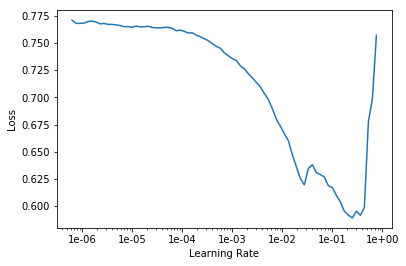

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,roc,time
1,0.738133,0.661016,0.920000,0.312738,00:03
2,0.635814,0.290275,0.930000,0.737904,00:03
3,0.490014,1.137702,0.820000,0.572051,00:03
4,0.389754,0.499240,0.930000,0.639702,00:03
5,0.316712,0.735336,0.910000,0.550591,00:03
6,0.259061,1.159080,0.920000,0.441243,00:03
7,0.215688,0.796645,0.900000,0.525783,00:03
8,0.179806,0.637302,0.920000,0.545883,00:03
9,0.153234,0.618181,0.920000,0.552628,00:03
10,0.131276,0.598367,0.920000,0.556052,00:03


In [22]:
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


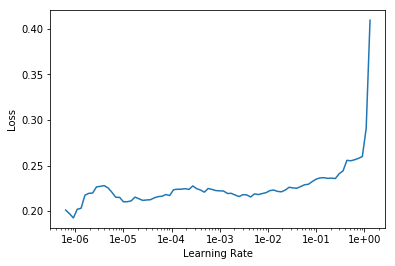

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
1,0.240046,0.319444,0.913275,00:21
2,0.246660,0.297672,0.912875,00:20
3,0.230240,0.308673,0.913100,00:20
4,0.237864,0.438615,0.912725,00:19
5,0.247343,0.263681,0.912800,00:20


In [25]:
learn.save('state-2')

# Final prediction and submission to Kaggle

In [ ]:
learn.load('state-2')

In [37]:
preds, _ = learn.get_preds(DatasetType.Test)
# labels = np.argmax(preds, 1)
assert(len(test_df) == len(preds))

In [32]:
submission_df = pd.DataFrame({'ID_code': test_df['ID_code'], 'target': test_predictions})

In [33]:
submission_df.head()

,ID_code,target
0,test_0,0.388123
1,test_1,0.639614
2,test_2,0.505451
3,test_3,0.652462
4,test_4,0.298859


In [34]:
submission_file = data_path/'submission_lgbm_fold10.csv'
submission_df.to_csv(submission_file, index=False)

In [35]:
# Only 3 submission allowed per day!
!kaggle competitions submit {competition_name} -f {submission_file} -m "LightGBM, 10 folds, different seed"

100%|██████████████████████████████████████| 5.91M/5.91M [00:01<00:00, 3.28MB/s]
Successfully submitted to Santander Customer Transaction Prediction